In [74]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from numpy import mean
from numpy import std
from numpy import absolute
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
import xgboost as xgb

ModuleNotFoundError: No module named 'tensorflow'

Let's start of by getting one-hot-encoding in the dataframe. 

In [55]:
listings = pd.read_csv('../data/preprocessed.csv')
listings = pd.get_dummies(listings)

Now I want to see the correlations between price and the columns.

In [56]:
from pandas.api.types import is_numeric_dtype
print('Correlations')
correlations = []
for column in listings.columns:
    if column == 'price':
        continue
    if not(is_numeric_dtype(listings[column])):
        continue
    correlation = listings['price'].corr(listings[column])
    correlations.append((column, correlation))
sorted(correlations,key=lambda tup: tup[1])

Correlations


[('room_type_Private room', -0.4107699406325351),
 ('property_type_Apartment', -0.1813801071974995),
 ('cancellation_policy_flexible', -0.14798179462264066),
 ('smoking_allowed', -0.1404438703491207),
 ('neighbourhood_group_cleansed_Neukölln', -0.11512533793239492),
 ('host_response_time_Unknown', -0.10550396122960079),
 ('translation_missing:_en.hosting_amenity_49', -0.10055390929096637),
 ('translation_missing:_en.hosting_amenity_50', -0.09886826072817724),
 ('neighbourhood_cleansed_Rixdorf', -0.07320676375471448),
 ('room_type_Shared room', -0.06234980387892072),
 ('neighbourhood_cleansed_Neuköllner Mitte/Zentrum', -0.06056024464648791),
 ('neighbourhood_cleansed_Wedding Zentrum', -0.05619997464772085),
 ('neighbourhood_cleansed_Parkviertel', -0.05338767572222585),
 ('neighbourhood_cleansed_Osloer Straße', -0.046091561354893965),
 ('bed_type_Futon', -0.04219053932244693),
 ('neighbourhood_group_cleansed_Lichtenberg', -0.04134326632338802),
 ('bed_type_Pull-out Sofa', -0.041277750280

In [57]:
uncorrelated_columns = [column for (column, correlation) in correlations if abs(correlation) < .1]

In [58]:
listings = listings.drop(uncorrelated_columns, axis = 1)

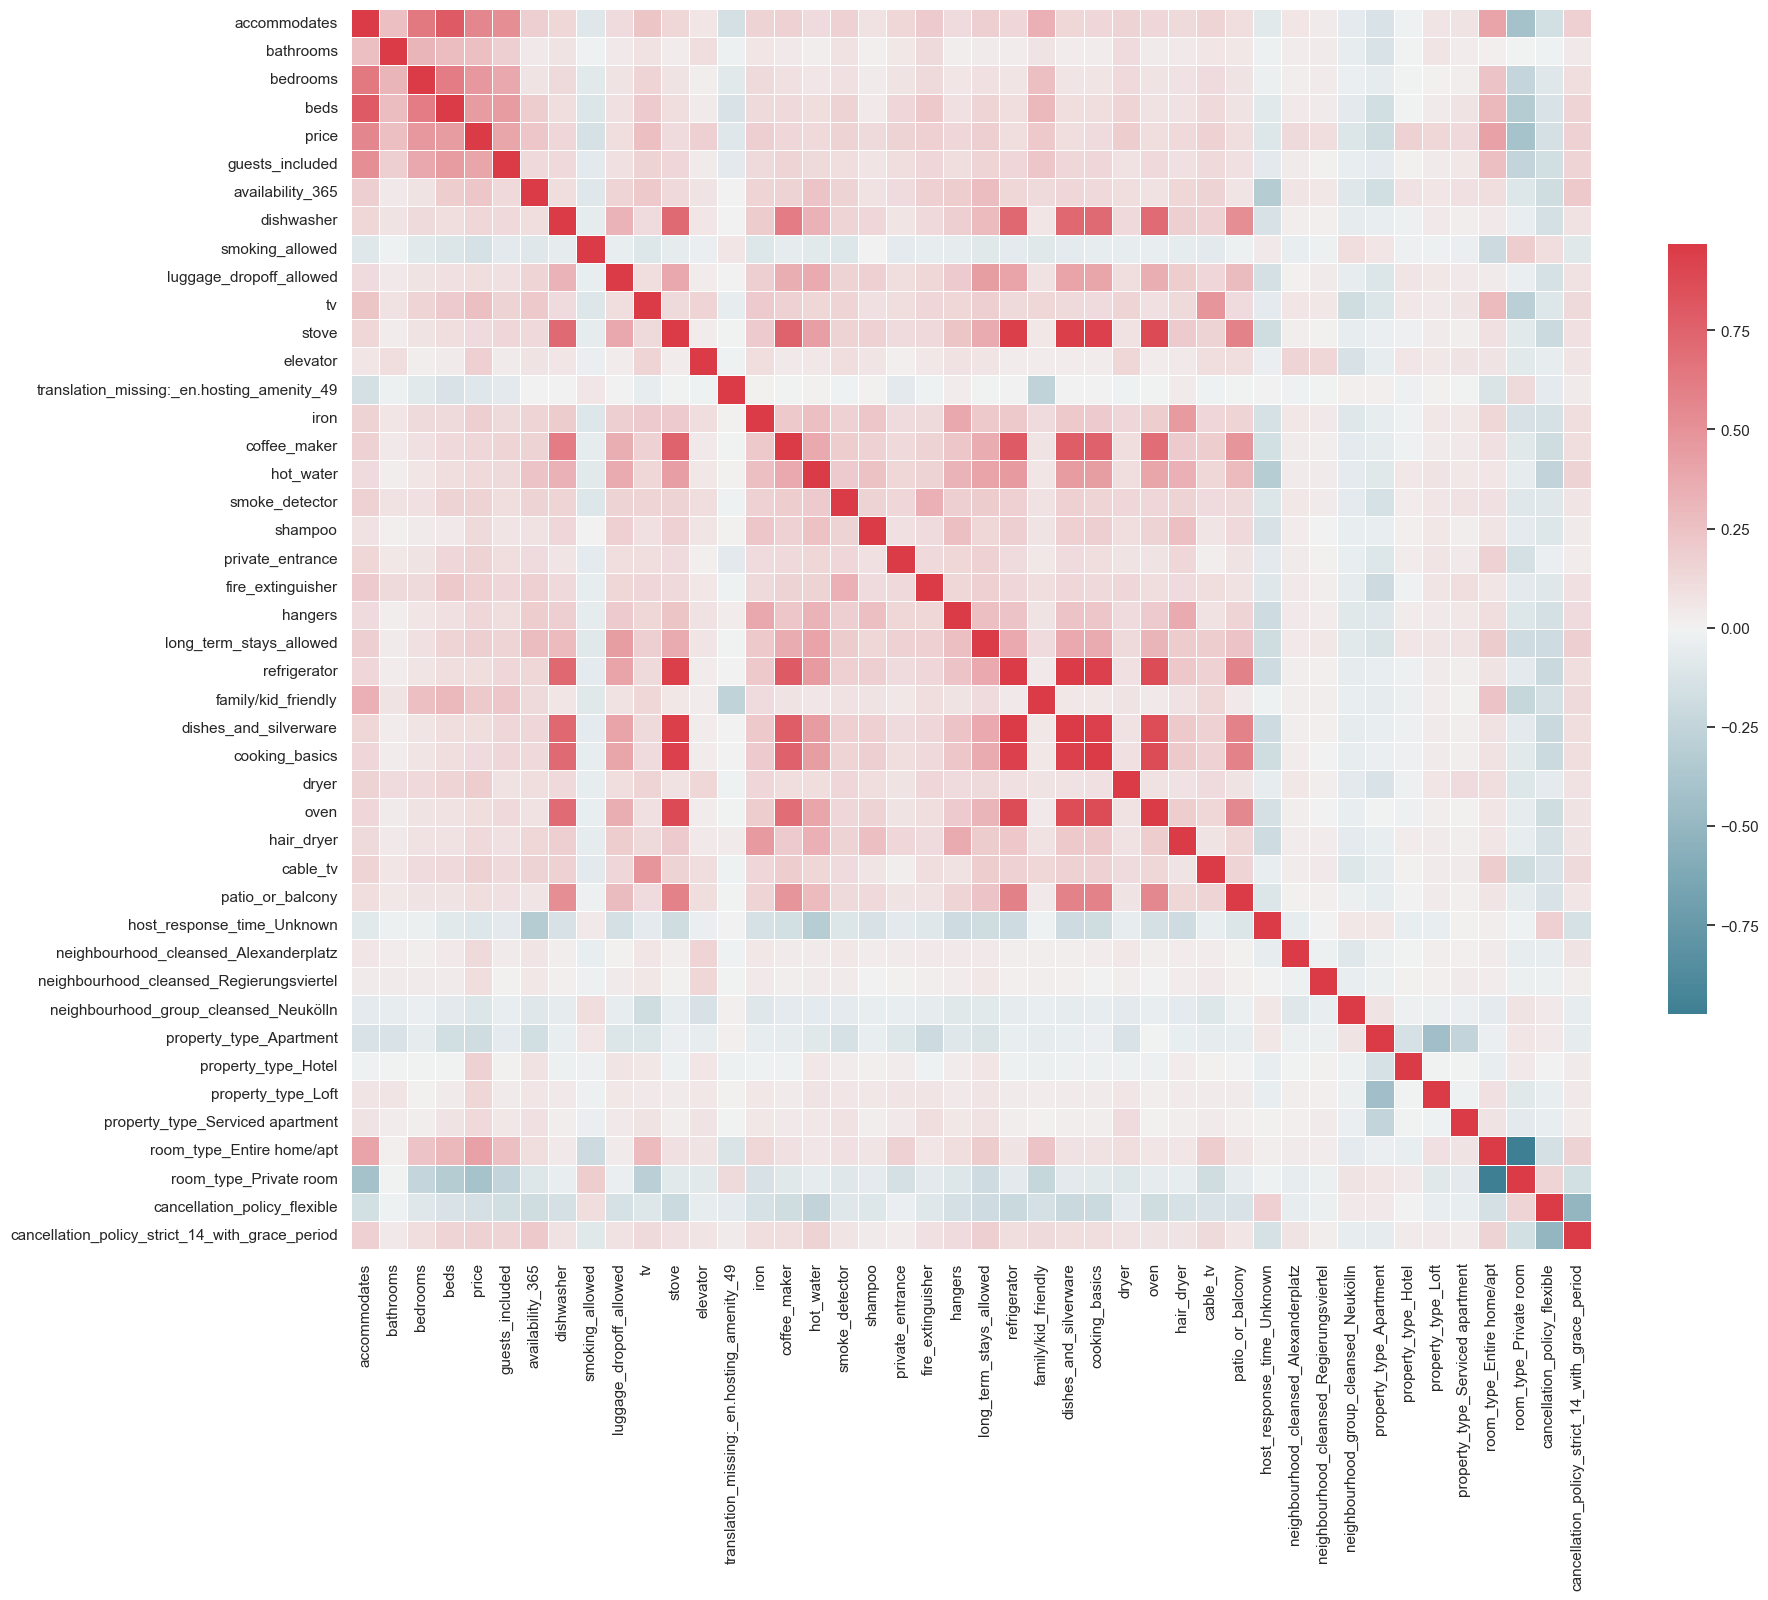

In [59]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr,cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max())

multi_collinearity_heatmap(listings, figsize=(20,20))

Our price is strongly correlated with how many people the listing sleeps. But I don't want correlating features for the linear regression model. So I'll remove 'bedrooms', 'beds' and 'guests_included'. It also seems like there are multiple ways to say you have a kitchen... So let's get rid of those highly correlating features. We'll keep 'cooking basics' and remove 'dishwasher, 'oven', 'stove', 'hot_water, 'refigerator', 'dishes_and_silverware'.
'tv' is correlated to 'cable_tv'. From the two, 'tv' is the most important for price, so I'll remove 'cable_tv' as well.

In [60]:
kitchen_supplies = ['dishwasher', 'oven', 'stove', 'hot_water', 'refrigerator', 'dishes_and_silverware', 'coffee_maker']
amt_of_people = ['bedrooms', 'beds', 'guests_included']
others = ['cable_tv']
drop_out = kitchen_supplies + amt_of_people + others

In [61]:
listings = listings.drop(drop_out, axis = 1)

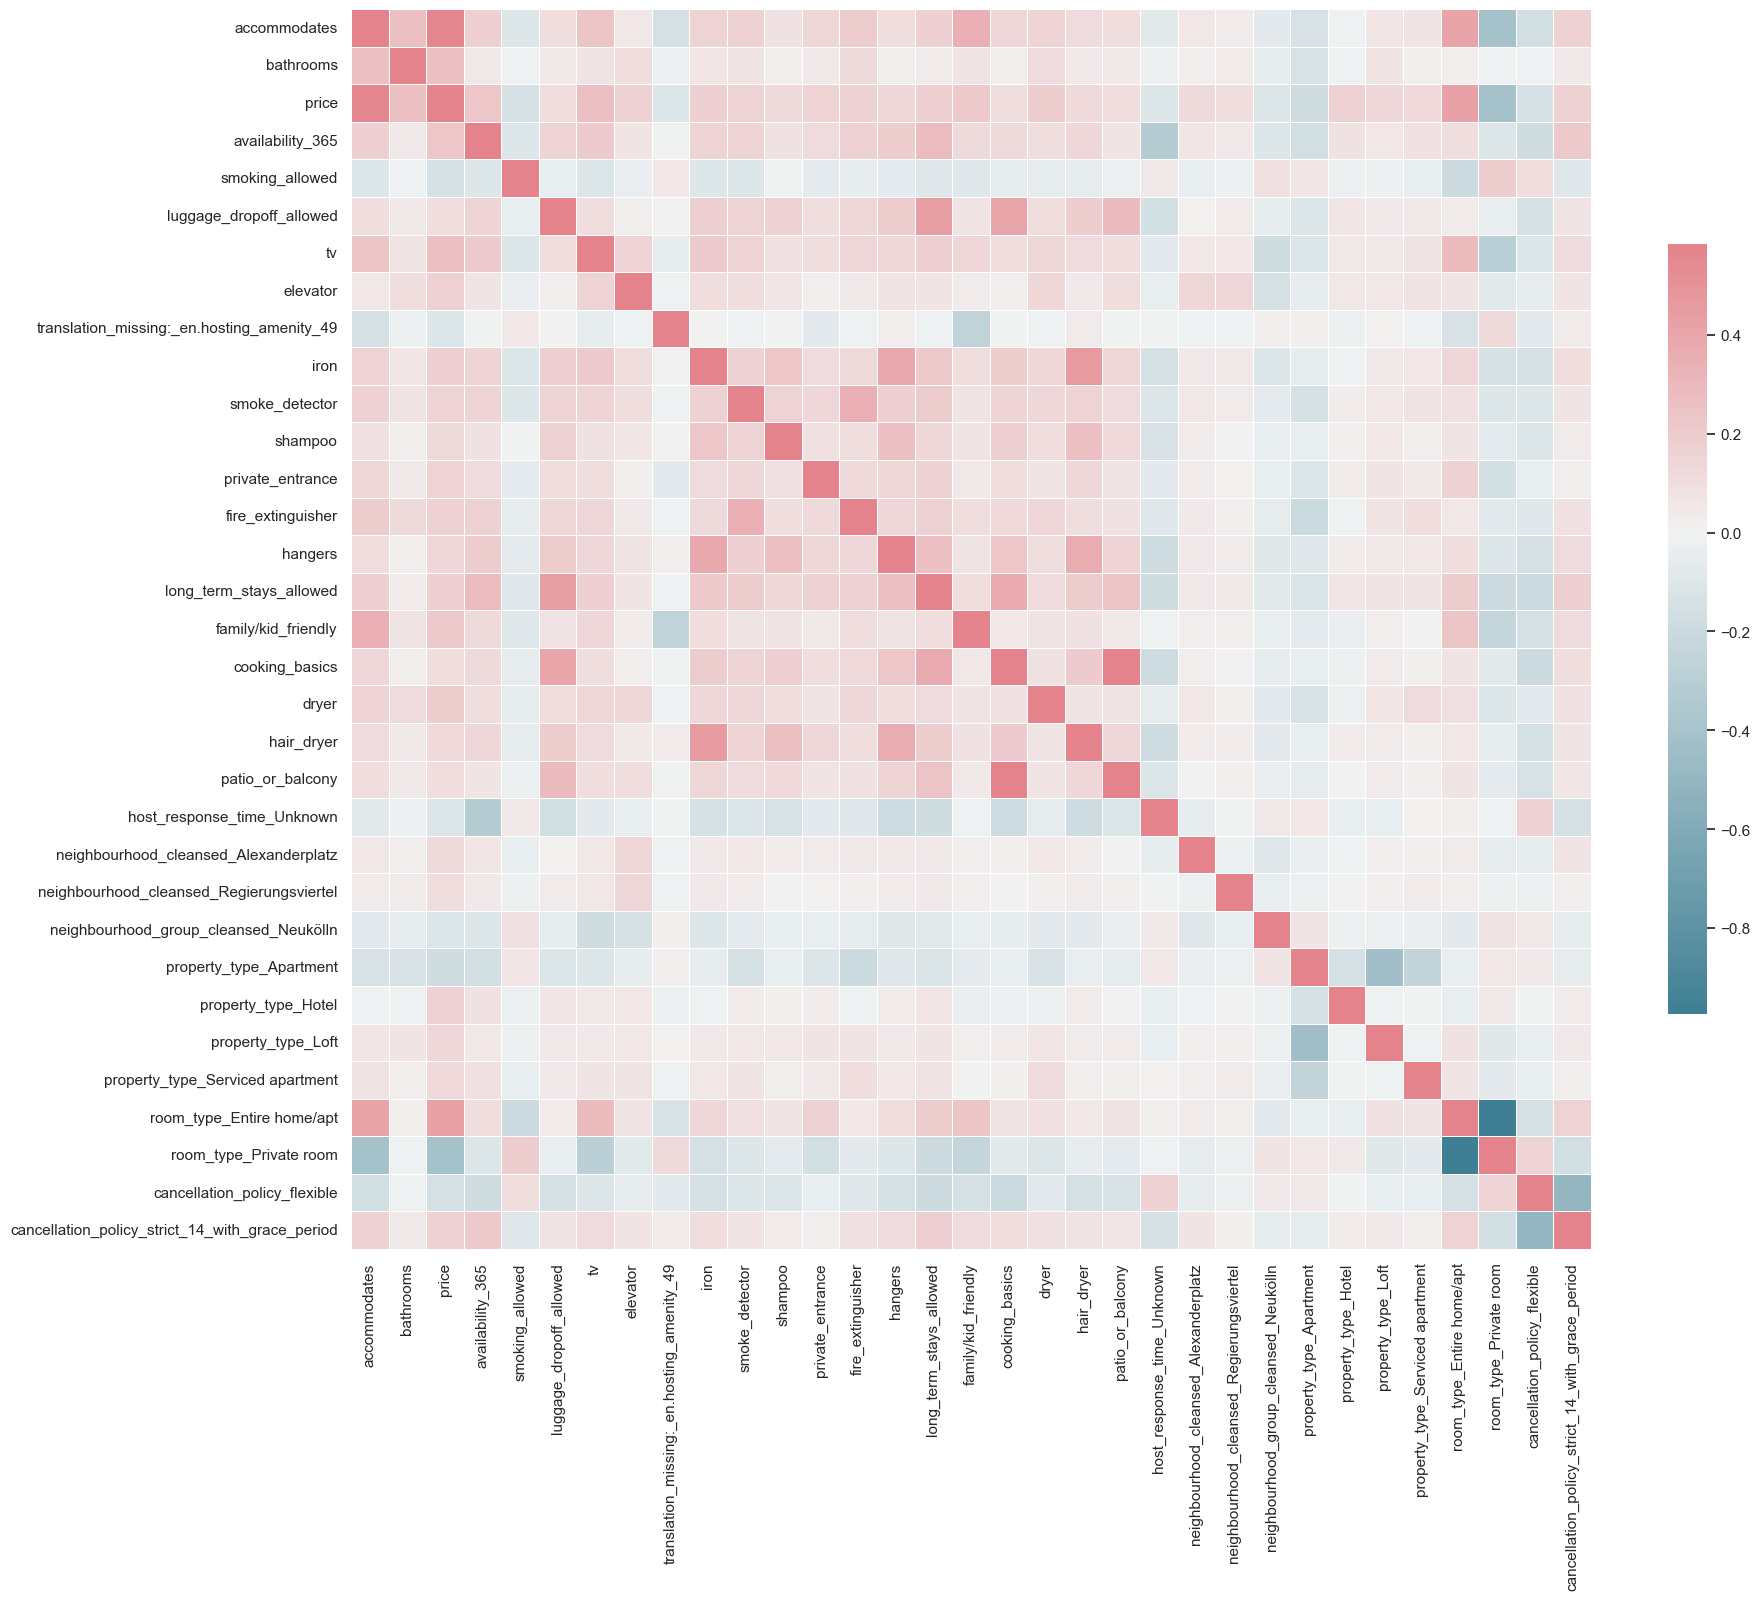

In [62]:
multi_collinearity_heatmap(listings, figsize=(20,20))

In [63]:
# Separating X and y
X = listings.drop('price', axis=1)
y = listings['price']

# Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
reg = LinearRegression()  
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print("Training RMSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Training r2:", round(r2_score(y_train, y_train_pred),4))

print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training RMSE: 1139.2473
Training r2: 0.4602
Validation RMSE: 1092.8419
Validation r2: 0.4804


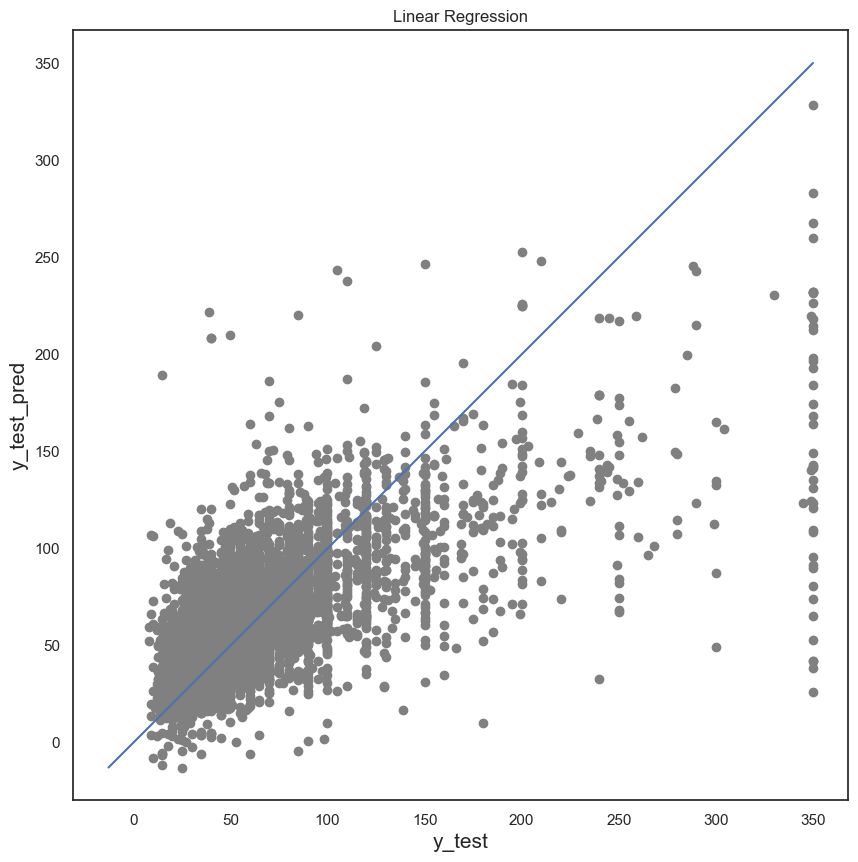

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred, c='grey')

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_test_pred', fontsize=15)
plt.title('Linear Regression')
plt.axis('equal')
plt.show()

In [66]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_train_preds_xgb = xgb_reg.predict(X_train)
y_test_preds_xgb = xgb_reg.predict(X_test)

print("Training MSE:", round(mean_squared_error(y_train, y_train_preds_xgb),4))
print("Training r2:", round(r2_score(y_train, y_train_preds_xgb),4))

print("Validation MSE:", round(mean_squared_error(y_test, y_test_preds_xgb),4))
print("Validation r2:", round(r2_score(y_test, y_test_preds_xgb),4))

Training MSE: 474.1519
Training r2: 0.7753
Validation MSE: 977.7373
Validation r2: 0.5351


The model explains around 53% of the variance around the mean. The mean squared error is very high, because the maximum price is 350.

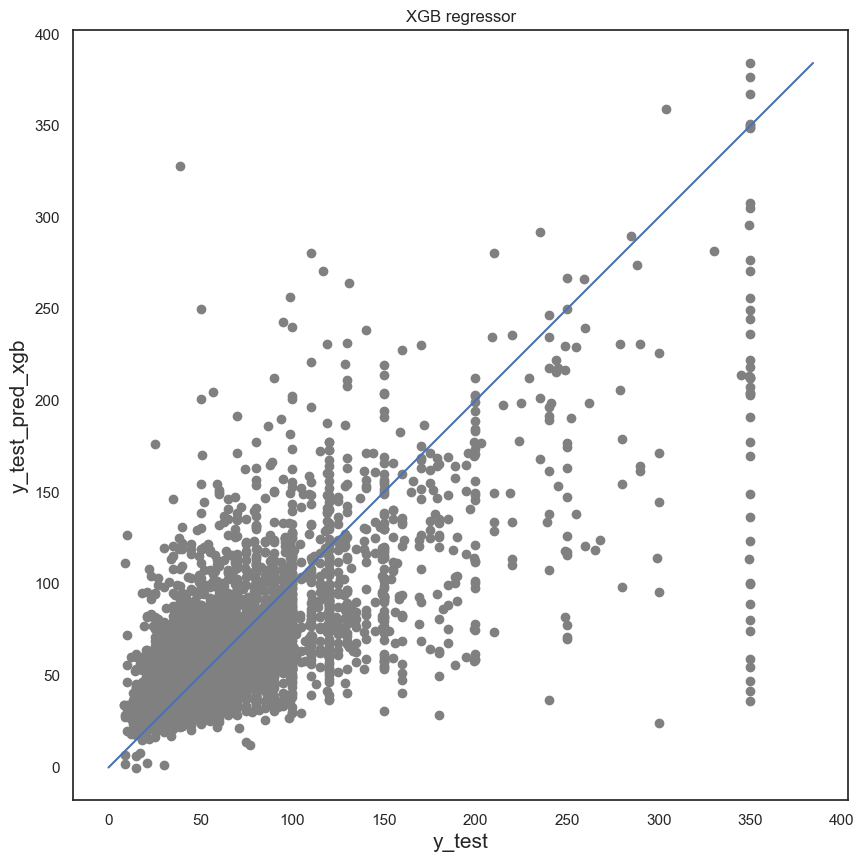

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_preds_xgb, c='grey')

p1 = max(max(y_test_preds_xgb), max(y_test))
p2 = min(min(y_test_preds_xgb), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_test_pred_xgb', fontsize=15)
plt.title('XGB regressor')
plt.axis('equal')
plt.show()

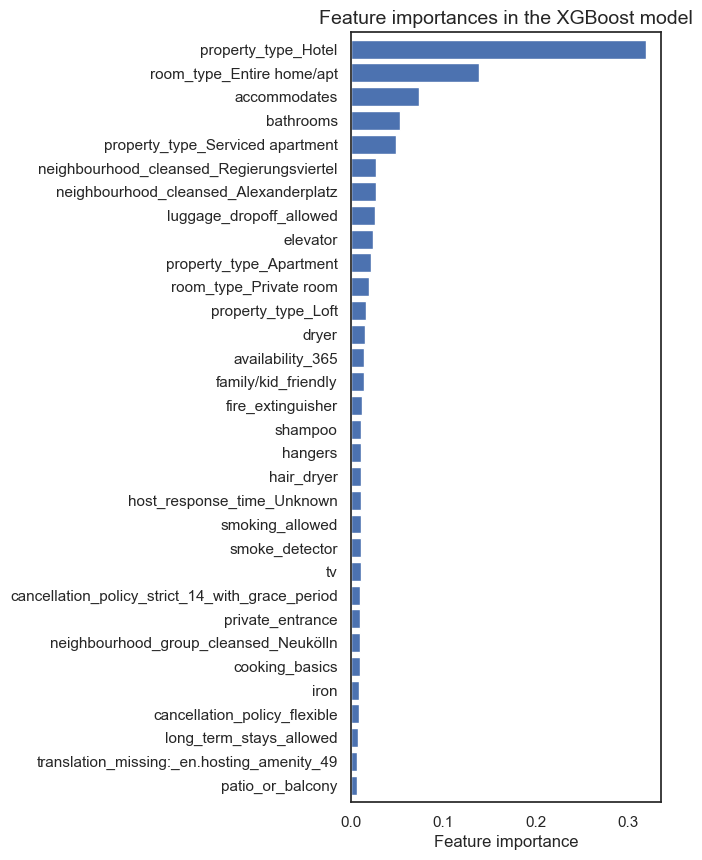

In [35]:
plt.figure(figsize=(4,10))
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [72]:
las = Lasso(alpha=1.0)
las.fit(X_train, y_train)

y_train_pred = las.predict(X_train)
y_test_pred = las.predict(X_test)

print("Training RMSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Training r2:", round(r2_score(y_train, y_train_pred),4))

print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366


In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
for depth in range(1,20):
    model = RandomForestRegressor(max_depth=depth, random_state=2)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f'depth: {depth}')
    print("Training RMSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Training r2:", round(r2_score(y_train, y_train_pred),4))

    print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

depth: 1
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 2
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 3
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 4
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 5
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 6
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 7
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 8
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 9
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation r2: 0.366
depth: 10
Training RMSE: 1388.9542
Training r2: 0.3419
Validation RMSE: 1333.431
Validation